In [1]:
import pandas as pd
import numpy as np
%matplotlib inline
from matplotlib import pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
import math
from matplotlib import cm
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
# plt.rcParams['figure.figsize'] = [10, 5]

In [2]:
def calc_di(distances, k, d_bar=True):
    di = distances.apply(lambda x: x.nsmallest(k).mean()).values
    return (di, di.mean()) if d_bar else di    

In [3]:
def cloud(references, tests, k):
    """
    reference: pd.DataFrame
        Should represent a distance matrix where rows and columns are indexed by reference sample ids
    tests: pd.DataFrame
        Should represent a distance matrix where row are indexed by reference sample ids and columns are indexed
        by tests sample ids
    k: int
        The number of k nearest neighbors to look at
    """
    reference_ids = references.columns.to_list()
    test_ids = tests.columns.to_list()
    # step 1 and 2
    r_di, d_bar = calc_di(references, k)
    
    # step 3
    r_ri = r_di / d_bar
    
    # step 4
    t_di = calc_di(tests, k, d_bar=False)
    t_ri = t_di / d_bar
    
    for i, t in enumerate(t_ri):
        e = np.sum(r_ri >= t)
        t_ri[i] = e
    t_ri = t_di / r_ri.shape[0]
    print(e)
    
    return (t_di)

In [4]:
def get_reference_set(distances, samples, ref_lam, s_r, p_k, num_samplings=10):
    # get full "normal" set
    distances = distances.loc[ref_lam(samples)]
    distances = distances[distances.index]
    
    # calculate k
    size = int(distances.shape[0] * s_r)
    k = int(p_k * size)
    _, d_bar = calc_di(distances, k)
    
    # find s_bar closest to d_bar
    best_ref = None
    best_bar_sep = np.inf
    for _ in range(num_samplings):
        ref_distances = distances.sample(size)
        ref_distances = ref_distances[ref_distances.index]
        _, s_bar = calc_di(ref_distances, k)
        s_bar_dist = s_bar - d_bar
        if s_bar_dist < best_bar_sep:
            best_ref = ref_distances
            best_bar_sep = s_bar_dist
    return (best_ref, k)

In [5]:
def get_ref_train_test(distances, samples, ref_lam, anom_lam, s_r, p_k):
    # get reference set
#     reference_distances = distances.loc[ref_lam(samples)]
#     reference_distances = reference_distances.sample(int(reference_distances.shape[0]*.6))
#     reference_distances = reference_distances[reference_distances.index]
    reference_distances, k = get_reference_set(distances, samples, ref_lam, s_r, p_k)
    ref_ids = np.array(reference_distances.index.to_list())
    
    # get train set
    train_set_distances = distances.loc[
        (anom_lam(samples)) & ~(samples.index.isin(ref_ids)),
        ref_ids
    ]
    train_set_distances = train_set_distances.sample(int(train_set_distances.shape[0]*.8))
    train_set_ids = train_set_distances.index.to_list()
    train_set_distances = train_set_distances.T
    
    test_set_distances = distances.loc[
        (anom_lam(samples)) & ~(samples.index.isin(np.concatenate((ref_ids, train_set_ids)))),
        reference_distances.index.to_list()
    ].T
    return (reference_distances, train_set_distances, test_set_distances, k)

In [6]:
distances = pd.read_csv("artifact_110218_021021-144748/BIOM/110218/distance-matrix.tsv", sep="\t", index_col=0)
distances = distances.replace(0, np.nan)
distance_ids = distances.index.to_list()
samples = pd.read_csv("artifact_110218_021021-144748/BIOM/110218/sample.tsv", sep="\t", index_col=0)
samples = samples.loc[distance_ids]
samples["gut"] = samples.env_package == "human-gut"
samples["skin"] = samples.env_package == "human-skin"
samples["oral"] = samples.env_package == "human-oral"

# get ref, train, test for m3 vs f4

In [7]:
# for i in (range(1, 10)):
#     ref_dist, train_dist, test_dist, k = get_ref_train_test(
#         distances,
#         samples,
#         lambda df: (df.host == "M3"),
#         lambda df: (df.host == "M3") | (df.host == "F4"),
#         0.6,
#         0.05
#     )
#     train_ids = train_dist.columns.to_list()
#     test_ids = test_dist.columns.to_list()

In [9]:
faith = pd.read_csv("artifact_110218_021021-144748/BIOM/110218/alpha-diversity.tsv", sep="\t", index_col=0)

# AUC for m3 vs f4

6
23
0.6842105263157895
37 1 1
4
0
0.7578947368421053
37 1 2
0
21
0.6947368421052632
37 1 3
0
15
0.7263157894736842
37 1 4
15
10
0.7684210526315789
37 1 5
2
4
0.6631578947368421
37 1 6
17
23
0.6947368421052632
37 1 7
12
27
0.7578947368421053
37 1 8
14
27
0.6947368421052632
37 1 9
0
40
0.6896551724137931
74 2 1
2
31
0.6666666666666666
74 2 2
68
3
0.6896551724137931
74 2 3
55
6
0.7011494252873564
74 2 4
50
3
0.6781609195402298
74 2 5
39
13
0.6436781609195402
74 2 6
13
46
0.7701149425287356
74 2 7
15
4
0.7241379310344828
74 2 8
73
52
0.7126436781609196
74 2 9
21
109
0.5875
111 3 1
44
17
0.7625
111 3 2
3
99
0.65
111 3 3
61
6
0.6125
111 3 4
73
73
0.6625
111 3 5
2
2
0.6375
111 3 6
20
7
0.6875
111 3 7
108
55
0.65
111 3 8
1
52
0.6375
111 3 9
20
60
0.625
149 4 1
8
106
0.6388888888888888
149 4 2
143
7
0.5555555555555556
149 4 3
18
19
0.625
149 4 4
29
50
0.6944444444444444
149 4 5
0
4
0.6527777777777778
149 4 6
19
1
0.6666666666666666
149 4 7
47
7
0.6944444444444444
149 4 8
6
63
0.638888888888888

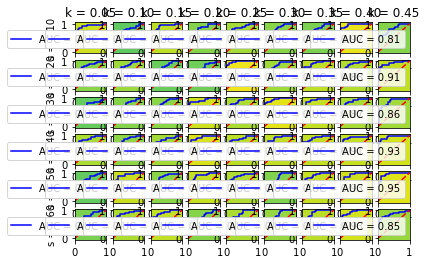

In [28]:
i_s, j_s = (6,9)
fig, axs = plt.subplots(i_s,j_s)
sizes = [0] * i_s
ks = [0] * j_s
aucs = np.zeros((i_s, j_s))  
viridis = cm.get_cmap("viridis")
# viridis()
for i in range(1, i_s+1):
    for j in range(1, j_s+1):
        ref_dist, train_dist, test_dist, k = get_ref_train_test(
            distances,
            samples,
            lambda df: (df.host == "M3") & (df.env_package == "human-oral"),
            lambda df: (df.env_package == "human-oral"),
            i * 0.1,
            j * 0.05
        )
        train_ids = train_dist.columns.to_list()
        test_ids = test_dist.columns.to_list()

        x1 = np.array(cloud(ref_dist, train_dist, k)).reshape(-1,1)
        x2 = faith.loc[train_dist.columns].values.reshape(-1,1)
        x3 = samples.loc[train_dist.columns, "gut"].values.reshape(-1,1)
        x4 = samples.loc[train_dist.columns, "oral"].values.reshape(-1,1)
        x5 = samples.loc[train_dist.columns, "skin"].values.reshape(-1,1)
        
#         x = np.hstack((x1,x2,x3,x4))
        x = x1
        y = samples.loc[train_ids, "host"] == "M3"
        y = np.array(y.to_list())
        y = y.reshape(y.size,)

        mdl = LogisticRegression()
        mdl = mdl.fit(x,y)

        x1 = np.array(cloud(ref_dist, test_dist, k)).reshape(-1,1)
        x2 = faith.loc[test_dist.columns].values.reshape(-1,1)
        x3 = samples.loc[test_dist.columns, "gut"].values.reshape(-1,1)
        x4 = samples.loc[test_dist.columns, "oral"].values.reshape(-1,1)
        x5 = samples.loc[test_dist.columns, "skin"].values.reshape(-1,1)
#         x = np.hstack((x1,x2, x3,x4))
        x = x1 #np.hstack((x1,x2, x3,x4))
        y = samples.loc[test_ids, "host"] == "M3"
        y = np.array(y.to_list())
        y = y.reshape(y.size,)
        probs = mdl.predict_proba(x)
        print(mdl.score(x, y))
        preds = probs[:,1]
        fpr, tpr, thres = metrics.roc_curve(y, preds)
        roc_auc = metrics.auc(fpr, tpr)

        axs[i-1, j-1].plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
        axs[i-1, j-1].legend(loc = 'lower right')
        axs[i-1, j-1].plot([0, 1], [0, 1],'r--')
        axs[i-1, j-1].set_xlim([0, 1])
        axs[i-1, j-1].set_xlim([0, 1])

        sizes[i-1] = i * 0.1
        ks [j-1] = j * 0.05
        aucs[i-1, j-1] = roc_auc
        print(ref_dist.shape[0], i, j)

b_colors = viridis(aucs)
for i in range(1, i_s+1):
    for j in range(1, j_s+1):
        axs[i-1, j-1].set_facecolor(b_colors[i-1,j-1])
        
for i in range(i_s):
    axs[i, 0].set_ylabel("s = %0.2f" % sizes[i])
        
for j in range(j_s):
    axs[0, j].set_title("k = %0.2f" % ks[j])

print(aucs)

# # Hide x labels and tick labels for top plots and y ticks for right plots.
#

In [23]:
for ax in axs.flat:
    ax.label_outer()

fig.set_size_inches(20,20)
fig.savefig('male-vs-female-no-skin.png', bbox_inches='tight')